# Measuring Fairness and Addressing Model Bias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import xgboost
from xgboost.sklearn import XGBClassifier

import aif360

In [3]:
pd.set_option('display.max_columns', 200)

## Create binary classes for each protected feature

In [4]:
train_main = pd.read_csv('data/application_train.csv', na_values=['','XNA','XAP'])

In [5]:
# missing value treatment
train_main = train_main[train_main['NAME_FAMILY_STATUS'] != 'Unknown']
train_main.shape

(307509, 122)

In [6]:
print(train_main['CODE_GENDER'].value_counts())
train_main.groupby(['CODE_GENDER'])['TARGET'].mean()

F    202447
M    105058
Name: CODE_GENDER, dtype: int64


CODE_GENDER
F    0.069994
M    0.101420
Name: TARGET, dtype: float64

In [7]:
# binary ordinal encoding of gender
train_main['IsMale'] = train_main['CODE_GENDER'].map(lambda x: 1 if x=='M' else 0)
train_main['IsMale'].value_counts()

0    202451
1    105058
Name: IsMale, dtype: int64

In [8]:
train_main.groupby(['CODE_GENDER'])['TARGET'].mean()

CODE_GENDER
F    0.069994
M    0.101420
Name: TARGET, dtype: float64

In [9]:
print(train_main['NAME_FAMILY_STATUS'].value_counts())
train_main.groupby(['NAME_FAMILY_STATUS'])['TARGET'].mean()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Name: NAME_FAMILY_STATUS, dtype: int64


NAME_FAMILY_STATUS
Civil marriage          0.099446
Married                 0.075599
Separated               0.081942
Single / not married    0.098077
Widow                   0.058242
Name: TARGET, dtype: float64

This shows that male is the group more likely to get unfavorable outcome.

In [13]:
# binary ordinal encoding of family status
train_main['IsSingle'] = train_main['NAME_FAMILY_STATUS'].map(
    lambda x: 1 if x in ["Single / not married", "Widow"] else 0)
train_main['IsSingle'].value_counts()

0    245977
1     61532
Name: IsSingle, dtype: int64

In [11]:
train_main.groupby(['IsSingle'])['TARGET'].mean()

IsSingle
0    0.081971
1    0.058242
Name: TARGET, dtype: float64

In [15]:
# binary ordinal encoding of age into <= 30 and >30
train_main['Age'] = -train_main['DAYS_BIRTH']/365

train_main['IsYoung'] = train_main['Age'].map(lambda x: 1 if x <= 30 else 0)
train_main['IsYoung'].value_counts()

0    262488
1     45021
Name: IsYoung, dtype: int64

In [16]:
train_main.groupby(['IsYoung'])['TARGET'].mean()

IsYoung
0    0.074925
1    0.114569
Name: TARGET, dtype: float64

In [17]:
# drop original columns
train_main = train_main.drop(columns=['CODE_GENDER','NAME_FAMILY_STATUS','DAYS_BIRTH','Age'])
train_main.shape

(307509, 122)

In [18]:
# data cleaning
# remove columns with more than 100000 missing values
na_sum = train_main.isna().sum().sort_values(ascending=False)
drop_cols = na_sum[na_sum>100000]
train_data = train_main.drop(columns=drop_cols.index)

# drop rows with missing values
train_data.dropna(inplace=True)

# convert object datatype to categorical datatype
train_data[train_data.select_dtypes(['object']).columns] = train_data.select_dtypes(['object']).apply(lambda x: x.astype('category'))

train_data.shape

(167732, 73)

In [19]:
# convert binary variables to categorical datatype
binary_cols = ['CNT_CHILDREN','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']
flag_cols = [col for col in train_data .columns if 'FLAG_DOCUMENT_' in col]
binary_cols.extend(flag_cols)

train_data[binary_cols] = train_data[binary_cols].astype('category')

In [20]:
# place the protected features and the target variable at the end of the dataset
y = train_data['TARGET']
X_train_data = train_data.drop(columns=['SK_ID_CURR','IsSingle','IsMale','IsYoung','TARGET'])
protected_cols = ['IsSingle','IsMale','IsYoung','TARGET']
protected = train_data[protected_cols]

In [21]:
numeric_features = X_train_data.select_dtypes(['int64','float64']).columns
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = X_train_data.select_dtypes(['category']).columns
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder())
    ]
)

In [100]:
X_train_data[numeric_features] = numeric_transformer.fit_transform(X_train_data[numeric_features])
X_train_data[categorical_features] = categorical_transformer.fit_transform(X_train_data[categorical_features])
X_train_data

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.0,0.0,1.0,0.0,0.076859,-0.524397,-0.222011,-0.550879,6.0,5.0,4.0,1.0,-0.134728,0.767265,0.304600,0.500716,0.0,1.0,0.0,1.0,1.0,0.0,8.0,-1.357044,-0.101555,-0.061264,6.0,-0.679758,-0.125993,-0.248873,-0.222233,-0.306372,-0.615023,-0.524271,5.0,-1.367968,-1.844872,0.232129,4.166220,0.241231,5.264228,-0.150318,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076400,-0.061733,-0.168538,-0.300471,-0.428749,-0.473353
2,1.0,1.0,1.0,0.0,-0.366730,-1.190007,-1.463318,-1.127866,6.0,5.0,4.0,1.0,-0.784080,0.939402,0.116137,0.226888,0.0,1.0,1.0,1.0,1.0,0.0,8.0,-1.357044,-0.101555,-0.061264,1.0,-0.985306,-0.125993,-0.248873,-0.222233,-0.306372,-0.615023,-0.524271,11.0,0.191546,1.168123,-0.585114,-0.316554,-0.583485,-0.271815,0.231774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076400,-0.061733,-0.168538,-0.300471,-0.428749,-1.024591
5,0.0,0.0,1.0,0.0,-0.263226,-0.318787,-0.027210,-0.274406,5.0,3.0,4.0,1.0,1.123470,0.369929,-0.102505,1.595361,0.0,1.0,1.0,1.0,1.0,0.0,8.0,-0.295127,-0.101555,-0.061264,6.0,1.153532,-0.125993,-0.248873,-0.222233,-0.306372,-0.615023,-0.524271,33.0,-0.882084,0.615033,-0.585114,-0.316554,-0.583485,-0.271815,-1.829607,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076400,-0.061733,-0.168538,-0.300471,1.232911,-0.473353
6,0.0,1.0,1.0,1.0,-0.026645,2.304051,0.925942,2.237890,6.0,1.0,1.0,1.0,1.123470,-0.274331,1.054450,1.500753,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.766789,-0.101555,-0.061264,3.0,1.153532,-0.125993,-0.248873,-0.222233,-0.306372,-0.615023,-0.524271,5.0,1.086317,-0.044376,-0.176492,-0.316554,-0.171127,-0.271815,-0.662969,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076400,-0.061733,-0.168538,0.738462,1.232911,0.077885
7,0.0,1.0,1.0,0.0,0.594379,2.228750,0.979465,2.598507,6.0,3.0,1.0,1.0,-1.295771,0.845813,0.012359,0.328158,0.0,1.0,1.0,1.0,0.0,0.0,10.0,-0.295127,1.888406,1.948486,1.0,1.153532,-0.125993,-0.248873,-0.222233,-0.306372,1.625956,1.907412,33.0,1.034572,0.203704,0.232129,-0.316554,0.241231,-0.271815,-0.073660,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.076400,-0.061733,-0.168538,-0.300471,-0.428749,-1.024591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.0,0.0,1.0,1.0,-0.278012,-0.969442,-1.195701,-0.887455,6.0,5.0,4.0,1.0,-0.714916,-2.616565,-1.242523,-1.105607,0.0,1.0,1.0,1.0,0.0,0.0,8.0,0.766789,-0.101555,-0.061264,1.0,1

In [101]:
feature_selector = SelectKBest(f_classif, k=20)
feature_selector.fit(X_train_data, y)
top_features = feature_selector.get_feature_names_out()
X = X_train_data[top_features]

c:\Users\S\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [16 42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\S\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [102]:
top_features

array(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'AMT_CREDIT',
       'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'FLAG_DOCUMENT_3'], dtype=object)

In [103]:
X = pd.concat((X, protected), axis=1)
X.drop(columns=['TARGET'], inplace=True)
X

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,AMT_CREDIT,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,IsSingle,IsMale,IsYoung
0,0.0,0.0,-0.524397,-0.550879,5.0,4.0,1.0,-0.134728,0.767265,0.304600,0.500716,-0.101555,-0.061264,-0.306372,-0.615023,-1.367968,-1.844872,4.166220,-0.150318,1.0,1,1,1
2,1.0,1.0,-1.190007,-1.127866,5.0,4.0,1.0,-0.784080,0.939402,0.116137,0.226888,-0.101555,-0.061264,-0.306372,-0.615023,0.191546,1.168123,-0.316554,0.231774,0.0,1,1,0
5,0.0,0.0,-0.318787,-0.274406,3.0,4.0,1.0,1.123470,0.369929,-0.102505,1.595361,-0.101555,-0.061264,-0.306372,-0.615023,-0.882084,0.615033,-0.316554,-1.829607,1.0,0,1,0
6,0.0,1.0,2.304051,2.237890,1.0,1.0,1.0,1.123470,-0.274331,1.054450,1.500753,-0.101555,-0.061264,-0.306372,-0.615023,1.086317,-0.044376,-0.316554,-0.662969,0.0,0,0,0
7,0.0,1.0,2.228750,2.598507,3.0,1.0,1.0,-1.295771,0.845813,0.012359,0.328158,1.888406,1.948486,-0.306372,1.625956,1.034572,0.203704,-0.316554,-0.073660,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.0,0.0,-0.969442,-0.887455,5.0,4.0,1.0,-0.714916,-2.616565,-1.242523,-1.105607,-0.101555,-0.061264,-0.306372,1.625956,-1.099756,1.196989,-0.316554,-0.607871,1.0,0,0,0
307503,0.0,0.0,-0.674106,-0.827352,1.0,1.0,1.0,0.161401,0.866703,1.220125,-0.709190,-0.101555,-0.061264,-0.306372,-0.615023,-0.099588,0.554023,6.407607,-1.564898,1.0,1,0,0
307508,0.0,0.0,0.139911,0.074190,5.0,1.0,1.0,-1.156556,-2.276051,-0.646647,-1.518015,1.888406,1.948486,-0.306372,1.625956,0.084068,-1.439100,-0.316554,-1.078599,1.0,0,0,0
307509,0.0,0.0,-0.613825,-0.635023,1.0,4.0,1.0,-1.133526,-0.966222,0.639030,1.292884,-0.101555,-0.061264,3.264004,1.625956,-0.030695,0.818202,-0.316554,0.822280,1.0,0,0,0


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, stratify=y_train, random_state =1)
print(X_train.shape, X_val.shape, X_test.shape)

(93929, 23) (40256, 23) (33547, 23)


## Visualizations

In [ ]:
train = pd.concat((X_train, y_train), axis=1)
val = pd.concat((X_val, y_val), axis=1)

In [ ]:
# xgboost
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train, y_train)

In [117]:
y_train_pred = xgb_clf.predict_proba(X_train)
y_val_pred = xgb_clf.predict_proba(X_val)
train['Prob'] = y_train_pred[:,1] # probability of class 1
val = X_val.copy()
val['Prob'] = y_val_pred[:,1] # probability of class 1
val = pd.concat((val, y_val), axis=1)

In [118]:
gender = train[['IsMale','Prob','TARGET']]
marital = train[['IsSingle','Prob','TARGET']]
age = train[['IsYoung','Prob','TARGET']]
gender

,IsMale,Prob,TARGET
84267,0,0.039330,0
80798,0,0.026947,0
49136,1,0.009972,0
265863,1,0.078206,0
92514,1,0.069370,0
...,...,...,...
171392,1,0.095860,1
157391,0,0.038661,0
289174,0,0.033584,0
166638,1,0.073244,0


### Predicted probability of class 1 using XGBoost

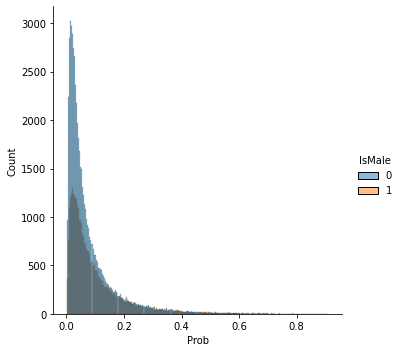

In [119]:
# probability of belonging to class 1
g = sns.displot(data=gender, x="Prob", hue="IsMale", alpha=0.5)

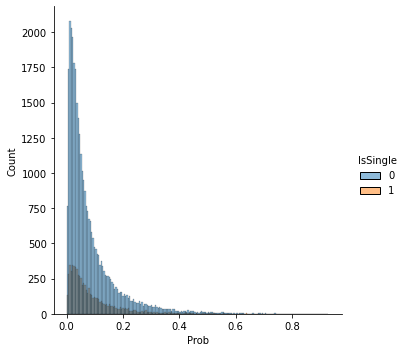

In [ ]:
# probability of belonging to class 1
g = sns.displot(data=marital, x="Prob", hue="IsSingle", alpha=0.5)

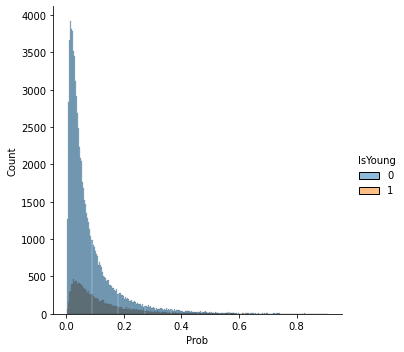

In [120]:
# probability of belonging to class 1
g = sns.displot(data=age, x="Prob", hue="IsYoung", alpha=0.5)

### Proportion of unfavorable outcome for each group in the dataset

According to the proportion of unfavorable outcome (target=1) in each group, we have the following.  
Gender: male(unprivileged), female(privileged)  
Marital status: Single(unprivileged), not single(privileged)  
Age: Under or equal to 30(unprivileged), older than 30(privileged)

<AxesSubplot:xlabel='IsMale', ylabel='TARGET'>

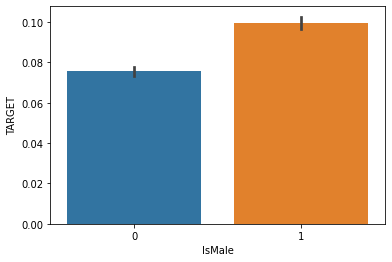

In [121]:
# proportion of unfavorable outcome (target=1) for each group
sns.barplot(x=gender["IsMale"], y=gender["TARGET"])

<AxesSubplot:xlabel='IsSingle', ylabel='TARGET'>

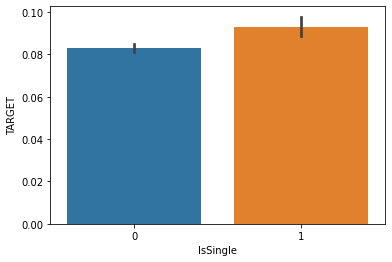

In [122]:
# proportion of unfavorable outcome (target=1) for each group
sns.barplot(x=marital["IsSingle"], y=marital["TARGET"])

<AxesSubplot:xlabel='IsYoung', ylabel='TARGET'>

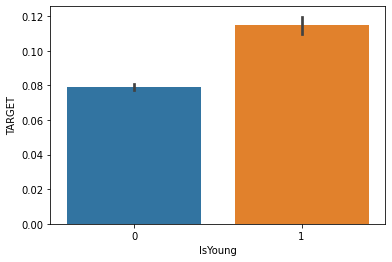

In [123]:
# proportion of unfavorable outcome (target=1) for each group
sns.barplot(x=age["IsYoung"], y=age["TARGET"])

### Disparate impact

In [124]:
def calc_prop(data, group_col, group, output_col, output_val):
    new = data[data[group_col] == group]
    return len(new[new[output_col] == output_val])/len(new)

In [125]:
# calculate the proportion of the privileged group (female) receiving the unfavourable outcome (target=1)
pr_priv = calc_prop(gender, "IsMale", 0, "TARGET", 1)
# calculate the proportion of the unprivileged group (male) receiving the unfavourable outcome (target=1)
pr_unpriv = calc_prop(gender, "IsMale", 1, "TARGET", 1)
print("proportion of privileged group (female) receiving unfavorable outcome:", pr_priv)
print("proportion of unprivileged group (male) receiving unfavorable outcome:", pr_unpriv)

proportion of privileged group receiving unfavorable outcome: 0.07552490843120734
proportion of unprivileged group receiving unfavorable outcome: 0.09961985688729874


In [126]:
# disparate impact
pr_unpriv/pr_priv

1.319033136968826

## Disparate Impact Remover

In [108]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360 import datasets
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer

In [216]:
train_BLD = datasets.BinaryLabelDataset(favorable_label='0',
                                unfavorable_label='1',
                                df=train,
                                label_names=['TARGET'],
                                protected_attribute_names=['IsMale'],
                                unprivileged_protected_attributes=['1'])
test_BLD = datasets.BinaryLabelDataset(favorable_label='0',
                                unfavorable_label='1',
                                df=val,
                                label_names=['TARGET'],
                                protected_attribute_names=['IsMale'],
                                unprivileged_protected_attributes=['0'])

In [229]:
di = DisparateImpactRemover(repair_level=1.0, sensitive_attribute='IsMale')
rp_train = di.fit_transform(train_BLD)
rp_test = di.fit_transform(test_BLD)

In [230]:
colnames = list(train.columns)
colnames.remove('TARGET')
colnames.append('TARGET')

In [231]:
train_repaired = pd.DataFrame(np.hstack([rp_train.features,rp_train.labels]), columns=colnames)
test_repaired = pd.DataFrame(np.hstack([rp_test.features,rp_test.labels]), columns=colnames)

In [232]:
train.shape

(93929, 25)

In [233]:
train_repaired.shape

(93929, 25)

In [234]:
# After removing bias from data, build a new model and check performance
xgb_new = XGBClassifier()
X_train_rp, y_train_rp = train_repaired.drop(columns=['TARGET']), train_repaired['TARGET']
X_test_rp, y_test_rp = test_repaired.drop(columns=['TARGET']), test_repaired['TARGET']
xgb_new.fit(X_train_rp, y_train_rp)
print('accuracy score:',xgb_new.score(X_test_rp, y_test_rp))

accuracy score: 0.9216017488076311


In [235]:
y_train_prob = xgb_new.predict_proba(X_train_rp)
y_test_prob = xgb_new.predict_proba(X_test_rp)

train_repaired['Prob'] = y_train_prob[:,1]
test_repaired['Prob'] = y_test_prob[:,1]

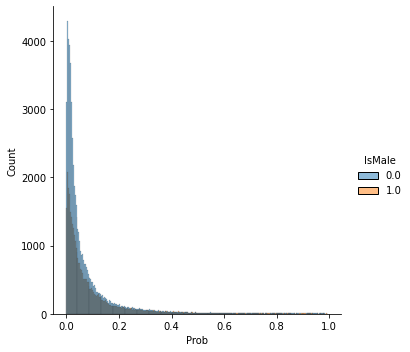

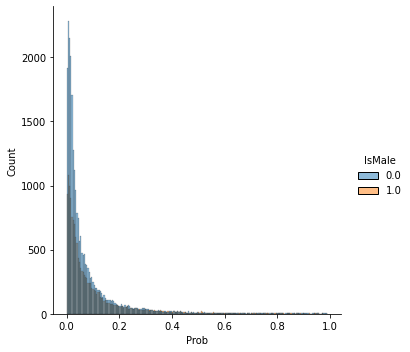

In [236]:
sns.displot(data=train_repaired, x="Prob", hue='IsMale', alpha=0.5)
sns.displot(data=test_repaired, x="Prob", hue='IsMale', alpha=0.5)

In [237]:
# calculate the proportion of the privileged group (female) receiving the unfavourable outcome (target=1)
pr_priv = calc_prop(test_repaired, "IsMale", 0, "TARGET", 1)
# calculate the proportion of the unprivileged group (male) receiving the unfavourable outcome (target=1)
pr_unpriv = calc_prop(test_repaired, "IsMale", 1, "TARGET", 1)
print("proportion of privileged group (female) receiving unfavorable outcome:", pr_priv)
print("proportion of unprivileged group (male) receiving unfavorable outcome:", pr_unpriv)

proportion of privileged group (female) receiving unfavorable outcome: 0.07612763046714682
proportion of unprivileged group (male) receiving unfavorable outcome: 0.09855223008504836


In [238]:
pr_unpriv/pr_priv

1.2945658426552362

## Fairness measure on predicted data

In [38]:
train_f = datasets.BinaryLabelDataset(favorable_label = 0, unfavorable_label = 1, df=train,
                                                      label_names=["TARGET"],
                                                     protected_attribute_names=["IsYoung","IsMale","IsSingle"],
                                              privileged_protected_attributes = [0,0,0])

In [48]:
pred_f = datasets.BinaryLabelDataset(favorable_label = 0.0, unfavorable_label = 1.0, df=X_val_pred,
                                                      label_names=["TARGET"],
                                                     protected_attribute_names=["IsYoung","IsMale","IsSingle"],
                                              privileged_protected_attributes = [0,0,0])

## Removing Bias

In [52]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover

In [53]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [61]:
val_f = datasets.BinaryLabelDataset(favorable_label = 0.0, unfavorable_label = 1.0, df=val,
                                                      label_names=["TARGET"],
                                                     protected_attribute_names=["IsYoung","IsMale","IsSingle"],
                                              privileged_protected_attributes = [0,0,0])

In [100]:
thresh_arr = np.linspace(0.01, 1, 10)
val_metrics = test(dataset=val_f,
                   model=xgb_clf,
                   thresh_arr=thresh_arr)
orig_best_ind = np.argmax(val_metrics['bal_acc'])

c:\Users\S\AppData\Local\Programs\Python\Python310\lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


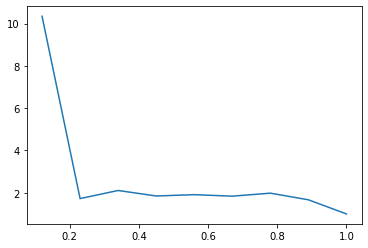

In [102]:
plt.plot(thresh_arr, val_metrics['disp_imp'])

In [67]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))

## Disparate impact remover

In [106]:
from aif360.datasets import BinaryLabelDataset

In [130]:
di = DisparateImpactRemover(repair_level=1.0)
rp_train = di.fit_transform(traindata)

In [125]:
df = aif360.datasets.BinaryLabelDataset(favorable_label=0.0, unfavorable_label=1.0, df=train, 
                                                      label_names=["TARGET"], 
                                                      protected_attribute_names=["IsYoung"],
                                                      privileged_protected_attributes = [0])

In [129]:
model = PrejudiceRemover()
prmodel = model.fit(df)